$\qquad$ $\qquad$$\qquad$  **TDA 231 Machine Learning: Homework 5** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: Clustering**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Aristide** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 21/5** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Name, Personal no., email** <br />
$\qquad$ $\qquad$$\qquad$                   ** Armand Ghaffarpour, 9101103738, armandg@student.chalmers.se**  <br />
$\qquad$ $\qquad$$\qquad$                   ** Ryan Damarputra Widjaja, 9002205616, ryand@student.chalmers.se** <br />

General guidelines:
* Since there is no theoretical part for this assigment, submit this ipynb only (with completed code/results).
* All discussion regarding practical problems, along with solutions and plots should be specified here itself. We will not generate the solutions/plots again by running your code.
* Your name, personal number and email address should be specified above.
* All datasets can be downloaded from the course website.
* All plots/tables and other relevant information should be included.

# Practical problems

The follwing code might be useful for this excercise.

```python
import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
print (mat.keys())
X = mat['X']
```

## [K-Means Implementation, 20 points]

a. Implement the basic (linear) $k$-means algorithm as described in the lecture, using the euclidean distance. Use (uniformly) random points from the data as initialization for the centroids. Terminate the iterative procedure when the the cluster assignments do not change.

b. Run your implementation on the matrix $X$ in **hw5_p1a.mat** with $k=2$. Each row of the matrix is an observation, and each column is a feature. Store the cluster assignment both after 2 iterations, and at convergence. Produce a scatter plot of the data with colors indicating the cluster assignments at convergence and highlight points that have changed assignment after the second iteration.

c. Implement the kernel $k$-means algorithm as described in the lecture, using the Gaussian RBF-kernel.

d. Run the linear $k$-means **and** your kernel $k$-means on **hw5_p1b.mat** with $k=2$. For the Gaussian RBF-kernel, use $\sigma=0.2$. Produce scatter plots of the data, with color indicating the cluster assignment at convergence, one plot for each of the algorithms.

For Practical a & b


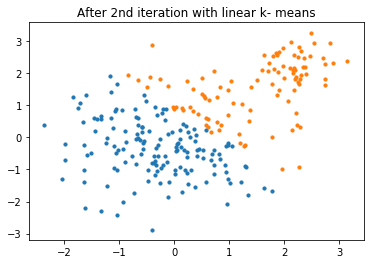

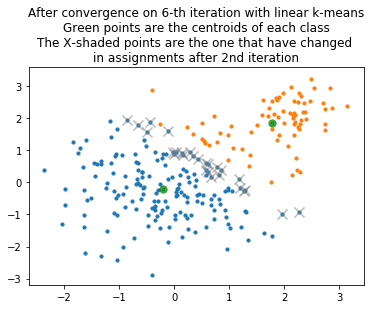

For Practical c & d


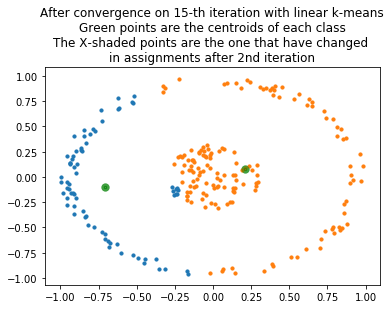

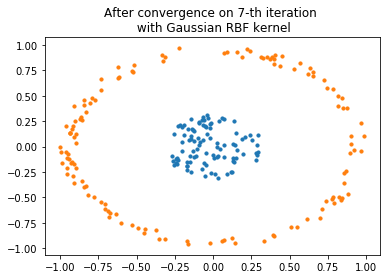

In [74]:
import scipy.io
import sklearn.metrics.pairwise as pw
import numpy as np
import matplotlib.pyplot as plt

# function for calculating the new mu manually
def newmu(points,labels):
    total_member = np.sum(labels)
    px = points[:,0] * labels
    py = points[:,1] * labels
    mu_x = np.divide((px.sum()),total_member)
    mu_y = np.divide((py.sum()),total_member)
    return[mu_x,mu_y]

# function for calculating the new mu with matrix multiplication method
def newmu2(points,labels):
    total_member = np.sum(labels)
    m_p = np.matrix(np.transpose(points))
    m_l = np.matrix(labels)
    mu = m_p * np.transpose(m_l)
    res = np.divide(mu,total_member)
    return np.transpose(np.array(res))


# function for calculating distance between a point and the 'centroids' of each class
# the calculation will be done with RBF kernel
# formula is taken straight from the lecture notes with some modifications to speed up the time
def distance(labels,bigkern,index):
    total_member = np.sum(labels)
    
    # Since we are using RBF kernel, k(x,x) will always be equal to 1 since it will result in exp(-gamma ||x-x||^2)
    # exp(0) = 1. Hence, term1 = 1
    term1 = 1
    
    z = np.matrix(labels)
    zz = np.multiply(z,np.transpose(z))
    
    kern = bigkern[index]
    term2 = z * kern.reshape(kern.shape[0],1)
    fin_term2 = np.divide(term2,total_member)
        
    term3 = np.multiply(zz,bigkern)    
    sum_term3 = np.sum(term3)
    fin_term3 = np.divide(sum_term3,np.power(total_member,2))
    
    res = term1 - (2 * fin_term2) + fin_term3
    return res    

def kernelKMeans(k,points,sigma):
    # initialization. l is the shape of original_labels
    l = (points.shape[0],k)
    original_labels = np.zeros(l)
    iteration = 0
    
    # precompute pairwise kernel-matrix
    # gamma is defined as 1/(2 * sigma^2)
    # bigkern is a matrix of N x N, consists of RBF kernel values of each pair of points
    gamma = np.divide(1,2 * (np.square(sigma)))
    bigkern = pw.rbf_kernel(points,points,gamma)
    
    # assign each point to a random class
    for i in range(0,points.shape[0]):
        cls = np.random.randint(0,k)
        original_labels[i][cls] = 1

    # calculating the new labels with RBF kernel
    while(True):
        iteration += 1
        if(iteration==1):
            input_labels = original_labels
        else:
            input_labels = new_labels
        new_labels = np.zeros(l)
        
        # calculating the new labels
        for j in range(0, points.shape[0]):
            curr = points[j]
            min_d = np.inf
            sel = 0
            for c in range(0,k):
                dist = distance(input_labels[:,c],bigkern,j)
                if (dist<min_d):
                    min_d = dist
                    sel = c
            new_labels[j][sel] = 1
        
        # if new_labels and input_labels are the same, break the while loop
        if(np.array_equal(new_labels,input_labels)==True):
            break
        
    # plot the points
    plt.figure()
    plt.title("After convergence on {}-th iteration \n with Gaussian RBF kernel".format(iteration))
    for i in range(0,k):
        px = points[:,0] * new_labels[:,i]
        py = points[:,1] * new_labels[:,i]
        plt.scatter(px[px!=0],py[py!=0],s=10)
    plt.show()
        
    
def linearKMeans(k,points,iteration_flag):
    # initialization, s is an array of mus, l is the shape of labels array
    s = (k,2)
    l = (points.shape[0],k)
    mu = np.zeros(s)
    labels = np.zeros(l)
    iteration = 0;
    second_iteration_labels = np.zeros(l)
    different_labels = np.zeros(l)
    
    #select random point as mus
    for i in range (0,k):
        ind = np.random.randint(0,points.shape[0])
        mu[i] = points[ind]
    
    # begin the linear kernel process
    while(True):
        # counting interation variable
        iteration += 1
        
        #calculating the new labels / assignments with linear k-means
        for j in range(0,points.shape[0]):
            curr = points[j]
            min_d = np.inf
            sel = 0
            for l in range(0,k):
                mu_k = mu[l]
                diff = np.subtract(curr,mu_k)
                d = np.sqrt(np.dot(diff,diff))
                if(d<min_d):
                    min_d = d
                    sel = l
            labels[j][sel] = 1
        
        #set the new mus
        for i in range(0,k):
            mu_new = newmu2(points,labels[:,i])
            mu[i] = mu_new
            
        #if 2nd iteration, plot the points
        if(iteration == 2 and iteration_flag == True):
            second_iteration_labels = labels
            plt.figure()
            plt.title("After 2nd iteration with linear k- means")
            for i in range(0,k):
                px = points[:,0] * labels[:,i]
                py = points[:,1] * labels[:,i]
                plt.scatter(px[px!=0],py[py!=0],s=10)
            plt.show()
        
        # store the calculated labels into "oldlabels" variable, and then initialize labels for the next iteration
        if(iteration == 1):
            oldlabels = labels
            labels = np.zeros(labels.shape)
        else:
            # if labels and oldlabels is equal, then break the while loop
            if(np.array_equal(oldlabels,labels) == True):
                break
            else:
                oldlabels = labels
                labels = np.zeros(labels.shape)
                
    #plot the points
    if(iteration_flag==True):
        different_labels = np.absolute(np.subtract(labels,second_iteration_labels))
    
    plt.figure()
    plt.title("After convergence on {}-th iteration with linear k-means\nGreen points are the centroids of each class\nThe X-shaded points are the one that have changed \nin assignments after 2nd iteration".format(iteration))
    for i in range(0,k):
        px = points[:,0] * labels[:,i]
        py = points[:,1] * labels[:,i]
        
        px2 = points[:,0] * different_labels[:,i]
        py2 = points[:,1] * different_labels[:,i]
        
        plt.scatter(px[px!=0],py[py!=0],s=10)
        plt.scatter(px2[px2!=0],py2[py2!=0],s=100,marker='x',color='gray',alpha=0.3)
        plt.scatter(mu[:,0],mu[:,1],linewidth=5,alpha=0.5,color='green',s=10)
    plt.show()
    
# main
mat = scipy.io.loadmat('hw5_p1a.mat')
mat2 = scipy.io.loadmat('hw5_p1b.mat')
X = mat['X']
X2 = mat2['X']

xl = X2[:,0]
yl = X2[:,1]

sigma = 0.2

# Practical a & b
print("For Practical a & b")
linearKMeans(2,X,True)

# Practical c & d
print("For Practical c & d")
linearKMeans(2,X2,False)
kernelKMeans(2,X2,sigma)